# Parking_Demand_Predict

[주차수요 예측 AI 경진대회](https://dacon.io/competitions/official/235745/overview/description)

# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:.4f}'.format
data_path = "./data/"
train_file = f"{data_path}train.csv"
test_file = f"{data_path}test.csv"
sample_submit_file = f"{data_path}sample_submission.csv"

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load Data

In [3]:
train = reduce_mem_usage(pd.read_csv(train_file, index_col=False))
test = reduce_mem_usage(pd.read_csv(test_file))

print(train.shape, test.shape)
print(set(train.columns) - set(test.columns))
display(train.head())

Mem. usage decreased to  0.20 Mb (40.0% reduction)
Mem. usage decreased to  0.07 Mb (37.5% reduction)
(2952, 15) (1022, 14)
{'등록차량수'}


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.7188,134,38.0000,A,15667000,103680,0.0000,3.0000,1425.0000,1015.0000
1,C2483,900,아파트,경상북도,국민임대,39.7188,15,38.0000,A,15667000,103680,0.0000,3.0000,1425.0000,1015.0000
2,C2483,900,아파트,경상북도,국민임대,51.9375,385,38.0000,A,27304000,184330,0.0000,3.0000,1425.0000,1015.0000
3,C2483,900,아파트,경상북도,국민임대,51.9375,15,38.0000,A,27304000,184330,0.0000,3.0000,1425.0000,1015.0000
4,C2483,900,아파트,경상북도,국민임대,51.9375,41,38.0000,A,27304000,184330,0.0000,3.0000,1425.0000,1015.0000


In [4]:
label = "등록차량수"

In [5]:
# 에러 데이터 제거

error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data:
    error_index = train[train['단지코드'] == error].index
    train.drop(error_index, inplace=True)

In [6]:
display(train.info())

display(train.describe().T)

display(train.describe(include="O").T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2876 non-null   object 
 1   총세대수                          2876 non-null   int16  
 2   임대건물구분                        2876 non-null   object 
 3   지역                            2876 non-null   object 
 4   공급유형                          2876 non-null   object 
 5   전용면적                          2876 non-null   float16
 6   전용면적별세대수                      2876 non-null   int16  
 7   공가수                           2876 non-null   float16
 8   자격유형                          2876 non-null   object 
 9   임대보증금                         2307 non-null   object 
 10  임대료                           2307 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2669 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2876 non-null   float16
 13  단지내

None

,count,mean,std,min,25%,50%,75%,max
총세대수,2876.0000,887.2997,517.2142,26.0000,514.0000,775.0000,1100.5000,2568.0000
전용면적,2876.0000,inf,inf,12.6172,32.0938,39.8438,51.0703,583.5000
전용면적별세대수,2876.0000,102.7079,133.1522,1.0000,14.0000,60.0000,142.2500,1865.0000
공가수,2876.0000,12.9141,10.6719,0.0000,4.0000,11.0000,20.0000,55.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2669.0000,0.1814,0.4321,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2876.0000,3.7070,2.6738,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2876.0000,inf,inf,13.0000,277.0000,502.0000,813.2500,1798.0000
등록차량수,2876.0000,inf,inf,13.0000,209.0000,480.0000,762.0000,2550.0000


,count,unique,top,freq
단지코드,2876,412,C1439,48
임대건물구분,2876,2,아파트,2314
지역,2876,16,경기도,602
공급유형,2876,10,국민임대,1734
자격유형,2876,15,A,1736
임대보증금,2307,926,24775000,22
임대료,2307,965,390000,19


## 중복 제거

In [8]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [9]:
print(train.shape, train.drop_duplicates().shape)
print(test.shape, test.drop_duplicates().shape)

(2552, 15) (2552, 15)
(949, 14) (949, 14)


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2552 non-null   object 
 1   총세대수                          2552 non-null   int16  
 2   임대건물구분                        2552 non-null   object 
 3   지역                            2552 non-null   object 
 4   공급유형                          2552 non-null   object 
 5   전용면적                          2552 non-null   float16
 6   전용면적별세대수                      2552 non-null   int16  
 7   공가수                           2552 non-null   float16
 8   자격유형                          2552 non-null   object 
 9   임대보증금                         2260 non-null   object 
 10  임대료                           2260 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2401 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2552 non-null   float16
 13  단지내

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          949 non-null    object 
 1   총세대수                          949 non-null    int16  
 2   임대건물구분                        949 non-null    object 
 3   지역                            949 non-null    object 
 4   공급유형                          949 non-null    object 
 5   전용면적                          949 non-null    float16
 6   전용면적별세대수                      949 non-null    int16  
 7   공가수                           949 non-null    float16
 8   자격유형                          947 non-null    object 
 9   임대보증금                         835 non-null    object 
 10  임대료                           835 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  915 non-null    float16
 12  도보 10분거리 내 버스정류장 수            949 non-null    float16
 13  단지내주

## 탐색

In [12]:
display(train.info())

display(train.describe().T)

display(train.describe(include="O").T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2552 non-null   object 
 1   총세대수                          2552 non-null   int16  
 2   임대건물구분                        2552 non-null   object 
 3   지역                            2552 non-null   object 
 4   공급유형                          2552 non-null   object 
 5   전용면적                          2552 non-null   float16
 6   전용면적별세대수                      2552 non-null   int16  
 7   공가수                           2552 non-null   float16
 8   자격유형                          2552 non-null   object 
 9   임대보증금                         2260 non-null   object 
 10  임대료                           2260 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2401 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2552 non-null   float16
 13  단지내

None

,count,mean,std,min,25%,50%,75%,max
총세대수,2552.0000,854.0435,487.8448,26.0000,504.0000,772.0000,1058.0000,2568.0000
전용면적,2552.0000,inf,inf,12.6172,36.4688,46.2188,51.7500,583.5000
전용면적별세대수,2552.0000,114.7190,136.4657,1.0000,26.0000,78.0000,154.0000,1865.0000
공가수,2552.0000,13.3281,10.5000,0.0000,4.0000,13.0000,20.0000,55.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2401.0000,0.1625,0.4226,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2552.0000,3.7031,2.7188,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2552.0000,inf,inf,13.0000,330.0000,548.0000,862.0000,1798.0000
등록차량수,2552.0000,inf,inf,13.0000,284.0000,509.0000,793.0000,2550.0000


,count,unique,top,freq
단지코드,2552,412,C2132,31
임대건물구분,2552,2,아파트,2267
지역,2552,16,경기도,590
공급유형,2552,10,국민임대,1706
자격유형,2552,15,A,1706
임대보증금,2260,926,24775000,22
임대료,2260,965,390000,19


array([[<AxesSubplot:title={'center':'총세대수'}>,
        <AxesSubplot:title={'center':'전용면적'}>,
        <AxesSubplot:title={'center':'전용면적별세대수'}>],
       [<AxesSubplot:title={'center':'공가수'}>,
        <AxesSubplot:title={'center':'도보 10분거리 내 지하철역 수(환승노선 수 반영)'}>,
        <AxesSubplot:title={'center':'도보 10분거리 내 버스정류장 수'}>],
       [<AxesSubplot:title={'center':'단지내주차면수'}>,
        <AxesSubplot:title={'center':'등록차량수'}>, <AxesSubplot:>]],
      dtype=object)

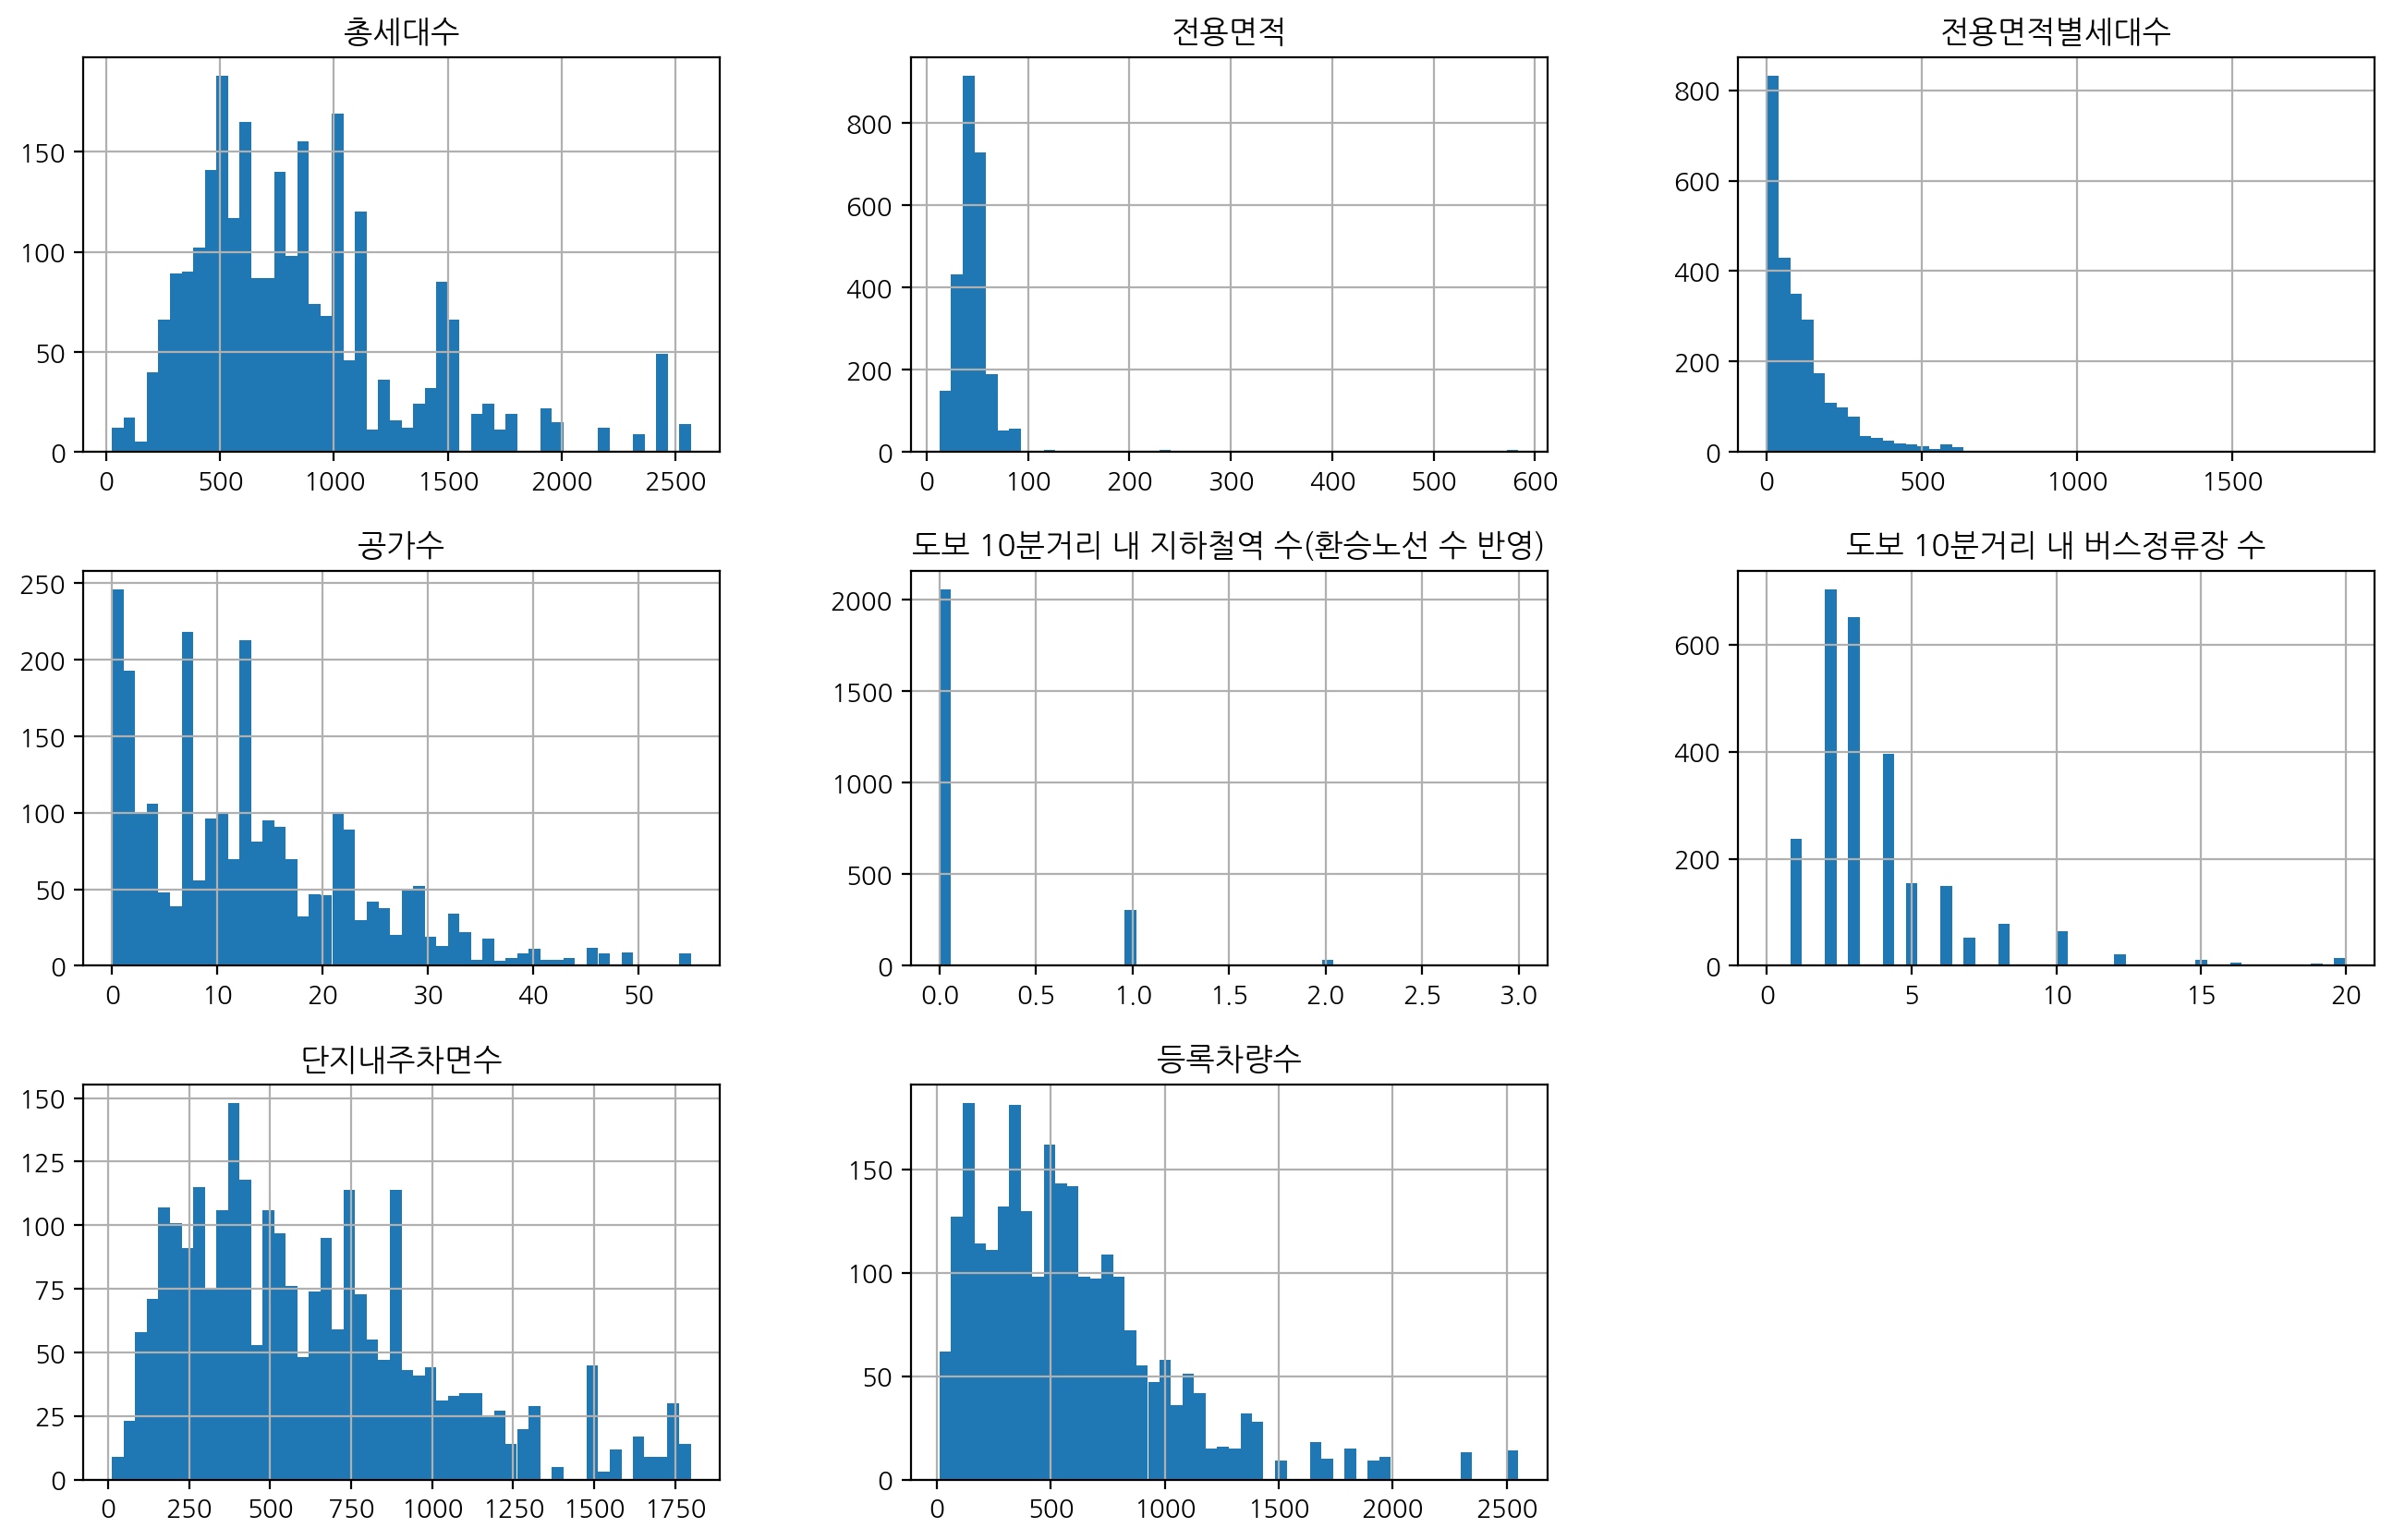

In [13]:
train.hist(figsize=(16,10), bins=50)

# Preprocessing

## 결측치

In [14]:
display(train.isnull().sum())

display(test.isnull().sum())

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           292
임대료                             292
도보 10분거리 내 지하철역 수(환승노선 수 반영)    151
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           114
임대료                             114
도보 10분거리 내 지하철역 수(환승노선 수 반영)     34
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [15]:
train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]] = (
    train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]]
    .fillna(0)
    .astype(np.uint8)
)
train["임대보증금"] = train["임대보증금"].replace("-", 0)
train["임대료"] = train["임대료"].replace("-", 0)
train[["임대보증금", "임대료"]] = train[["임대보증금", "임대료"]].fillna(0).astype(np.uint64)
display(train.isnull().sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

In [16]:
test[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]] = (
    test[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]]
    .fillna(0)
    .astype(np.uint8)
)
test["임대보증금"] = test["임대보증금"].replace("-", 0)
test["임대료"] = test["임대료"].replace("-", 0)
test[["임대보증금", "임대료"]] = test[["임대보증금", "임대료"]].fillna(0).astype(np.uint64)
display(test.isnull().sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            2
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
dtype: int64

In [17]:
display(train.info())

display(train.describe().T)

display(train.describe(include="O").T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2552 non-null   object 
 1   총세대수                          2552 non-null   int16  
 2   임대건물구분                        2552 non-null   object 
 3   지역                            2552 non-null   object 
 4   공급유형                          2552 non-null   object 
 5   전용면적                          2552 non-null   float16
 6   전용면적별세대수                      2552 non-null   int16  
 7   공가수                           2552 non-null   float16
 8   자격유형                          2552 non-null   object 
 9   임대보증금                         2552 non-null   uint64 
 10  임대료                           2552 non-null   uint64 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2552 non-null   uint8  
 12  도보 10분거리 내 버스정류장 수            2552 non-null   uint8  
 13  단지내

None

,count,mean,std,min,25%,50%,75%,max
총세대수,2552.0000,854.0435,487.8448,26.0000,504.0000,772.0000,1058.0000,2568.0000
전용면적,2552.0000,inf,inf,12.6172,36.4688,46.2188,51.7500,583.5000
전용면적별세대수,2552.0000,114.7190,136.4657,1.0000,26.0000,78.0000,154.0000,1865.0000
공가수,2552.0000,13.3281,10.5000,0.0000,4.0000,13.0000,20.0000,55.0000
임대보증금,2552.0000,22743702.6646,20219580.8515,0.0000,11426000.0000,18581000.0000,28856000.0000,213863000.0000
임대료,2552.0000,167509.1458,132670.1364,0.0000,90110.0000,144180.0000,217210.0000,1058030.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2552.0000,0.1528,0.4117,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2552.0000,3.7022,2.7184,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2552.0000,inf,inf,13.0000,330.0000,548.0000,862.0000,1798.0000
등록차량수,2552.0000,inf,inf,13.0000,284.0000,509.0000,793.0000,2550.0000


,count,unique,top,freq
단지코드,2552,412,C2132,31
임대건물구분,2552,2,아파트,2267
지역,2552,16,경기도,590
공급유형,2552,10,국민임대,1706
자격유형,2552,15,A,1706


In [18]:
test[test["자격유형"].isnull() == True]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.9062,240,25.0000,NaN,71950000,37470,0,2,840.0000
258,C2253,1161,아파트,강원도,영구임대,26.3750,745,0.0000,NaN,2249000,44770,0,2,173.0000


In [19]:
test[test["단지코드"] == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.4375,56,25.0000,A,11992000,100720,0,2,840.0000
194,C2411,962,아파트,경상남도,국민임대,39.7188,336,25.0000,A,11992000,100720,0,2,840.0000
195,C2411,962,아파트,경상남도,국민임대,39.8125,179,25.0000,A,11992000,100720,0,2,840.0000
196,C2411,962,아파트,경상남도,국민임대,46.9062,240,25.0000,NaN,71950000,37470,0,2,840.0000
197,C2411,962,아파트,경상남도,국민임대,51.9375,150,25.0000,A,21586000,171480,0,2,840.0000


In [20]:
test.loc[test["단지코드"].isin(["C2411"]) & test["자격유형"].isnull(), "자격유형"] = "A"

In [21]:
test[test["단지코드"] == 'C2253']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.3750,745,0.0000,NaN,2249000,44770,0,2,173.0000
259,C2253,1161,아파트,강원도,영구임대,31.3125,239,0.0000,C,3731000,83020,0,2,173.0000
260,C2253,1161,아파트,강원도,영구임대,31.3125,149,0.0000,C,3731000,83020,0,2,173.0000
261,C2253,1161,상가,강원도,임대상가,13.7734,1,0.0000,D,0,0,0,2,173.0000
262,C2253,1161,상가,강원도,임대상가,22.8906,1,0.0000,D,0,0,0,2,173.0000
263,C2253,1161,상가,강원도,임대상가,22.9062,1,0.0000,D,0,0,0,2,173.0000
264,C2253,1161,상가,강원도,임대상가,23.7969,1,0.0000,D,0,0,0,2,173.0000
266,C2253,1161,상가,강원도,임대상가,23.8594,1,0.0000,D,0,0,0,2,173.0000
268,C2253,1161,상가,강원도,임대상가,24.1875,1,0.0000,D,0,0,0,2,173.0000
269,C2253,1161,상가,강원도,임대상가,27.7500,1,0.0000,D,0,0,0,2,173.0000


In [22]:
test.loc[test["단지코드"].isin(["C2253"]) & test["자격유형"].isnull(), "자격유형"] = test[
    (test["단지코드"] == "C2253") & (test["공급유형"] == "영구임대")
]["자격유형"].mode()[0]

## index

In [23]:
train = train.set_index('단지코드')
test = test.set_index('단지코드')

# unique_cols = ['총세대수', '지역', '공가수', 
#                '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
#                '도보 10분거리 내 버스정류장 수',
#                '단지내주차면수', '등록차량수']
# train = train.set_index('단지코드')[unique_cols].drop_duplicates()
# test = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

## 스케일링

In [24]:
scailing_features = train.drop(columns="등록차량수").select_dtypes("number").columns.to_list()

print(scailing_features)

['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']


In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(train[scailing_features])

train[scailing_features] = scaler.transform(train[scailing_features])
test[scailing_features] = scaler.transform(test[scailing_features])

display(train[scailing_features].head())

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
단지코드,,,,,,,,,
C2515,-0.4097,-0.8344,1.5469,0.2500,-0.5373,-0.4818,0.0000,0.0000,0.1429
C2515,-0.4097,-0.4335,-0.1406,0.2500,-0.3390,-0.2915,0.0000,0.0000,0.1429
C2515,-0.4097,-0.4335,-0.4531,0.2500,-0.3390,-0.2915,0.0000,0.0000,0.1429
C2515,-0.4097,0.0450,-0.3125,0.2500,-0.0085,0.0439,0.0000,0.0000,0.1429
C2515,-0.4097,0.0450,-0.4609,0.2500,-0.0085,0.0439,0.0000,0.0000,0.1429


# corr

In [26]:
corr = pd.DataFrame(train.drop(columns = label).corrwith(train[label]))
corr_sort_abs = corr.sort_values(by=0, ascending=0, key=abs)
display(corr_sort_abs)

,0
단지내주차면수,0.8494
임대료,0.4707
총세대수,0.4351
임대보증금,0.3498
전용면적별세대수,0.1973
도보 10분거리 내 버스정류장 수,0.1275
공가수,0.1088
전용면적,0.0704
도보 10분거리 내 지하철역 수(환승노선 수 반영),-0.0624


In [27]:
corr_high = corr.loc[np.abs(corr_sort_abs[0]) > 0.1]
display(corr_high)
print(len(corr_high.index.to_list()))

,0
총세대수,0.4351
전용면적별세대수,0.1973
공가수,0.1088
임대보증금,0.3498
임대료,0.4707
도보 10분거리 내 버스정류장 수,0.1275
단지내주차면수,0.8494


7


<AxesSubplot:>

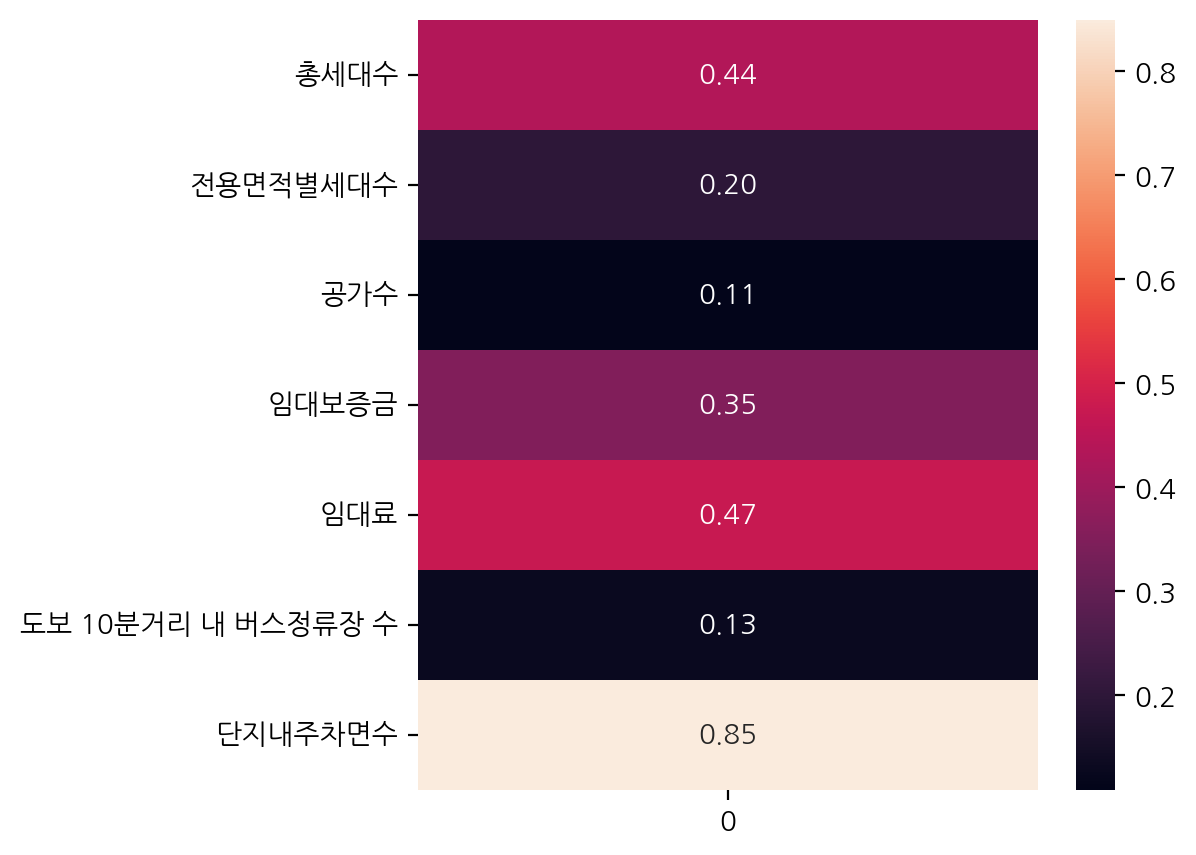

In [28]:
plt.figure(figsize = (5, 5))
sns.heatmap(data = corr_high, annot = True, fmt = '.2f')

# ML

## Dataset

In [31]:
features = corr_high.index.to_list()


print(label)
print(features)

등록차량수
['총세대수', '전용면적별세대수', '공가수', '임대보증금', '임대료', '도보 10분거리 내 버스정류장 수', '단지내주차면수']


In [32]:
from sklearn.model_selection import train_test_split

X = train[features]
y = train[label]
X_test = test[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state=42)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape)

(2041, 7) (511, 7) (949, 7)
(2041,) (511,)


## model

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2041 entries, C2362 to C2071
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   총세대수                2041 non-null   float64
 1   전용면적별세대수            2041 non-null   float64
 2   공가수                 2041 non-null   float64
 3   임대보증금               2041 non-null   float64
 4   임대료                 2041 non-null   float64
 5   도보 10분거리 내 버스정류장 수  2041 non-null   float64
 6   단지내주차면수             2041 non-null   float64
dtypes: float64(7)
memory usage: 127.6+ KB


In [ ]:
# cat_features = X_train.select_dtypes(include = 'object')
cat_features = "단지코드"

In [36]:
from catboost import CatBoostRegressor

cat_features = X_train.select_dtypes("O")

catb = CatBoostRegressor(
    loss_function="MAE",
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
)

## valid

In [37]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


In [38]:
from sklearn.model_selection import cross_val_predict

y_valid_pred = cross_val_predict(catb, X_train, y_train, cv=kf, n_jobs=-1, verbose=2)
print(y_valid_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[ 234.48773072  521.37022373  487.02022834 ... 1108.79518674  267.03332587
 1013.16543813]


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


In [39]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true = y_train, y_pred = y_valid_pred)
print(mae)

75.56389636504426


<AxesSubplot:xlabel='등록차량수'>

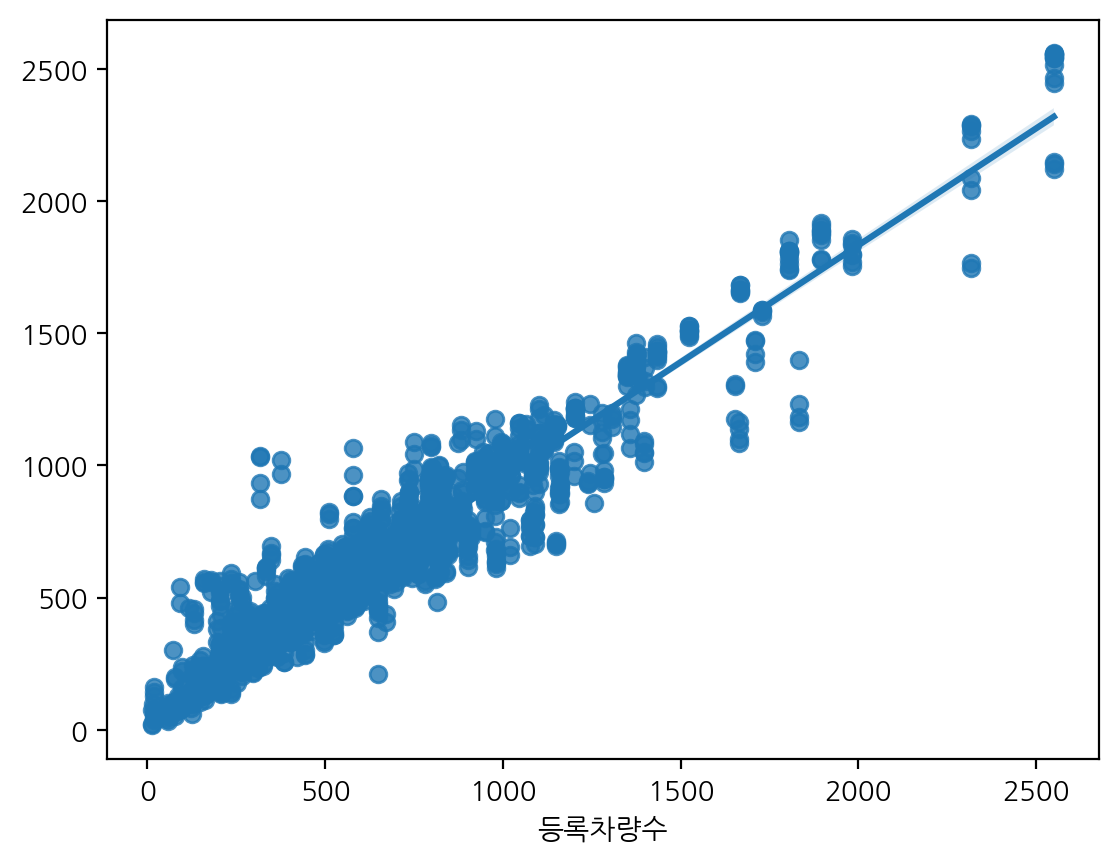

In [40]:
sns.regplot(x=y_train, y=y_valid_pred)

<AxesSubplot:xlabel='등록차량수', ylabel='Density'>

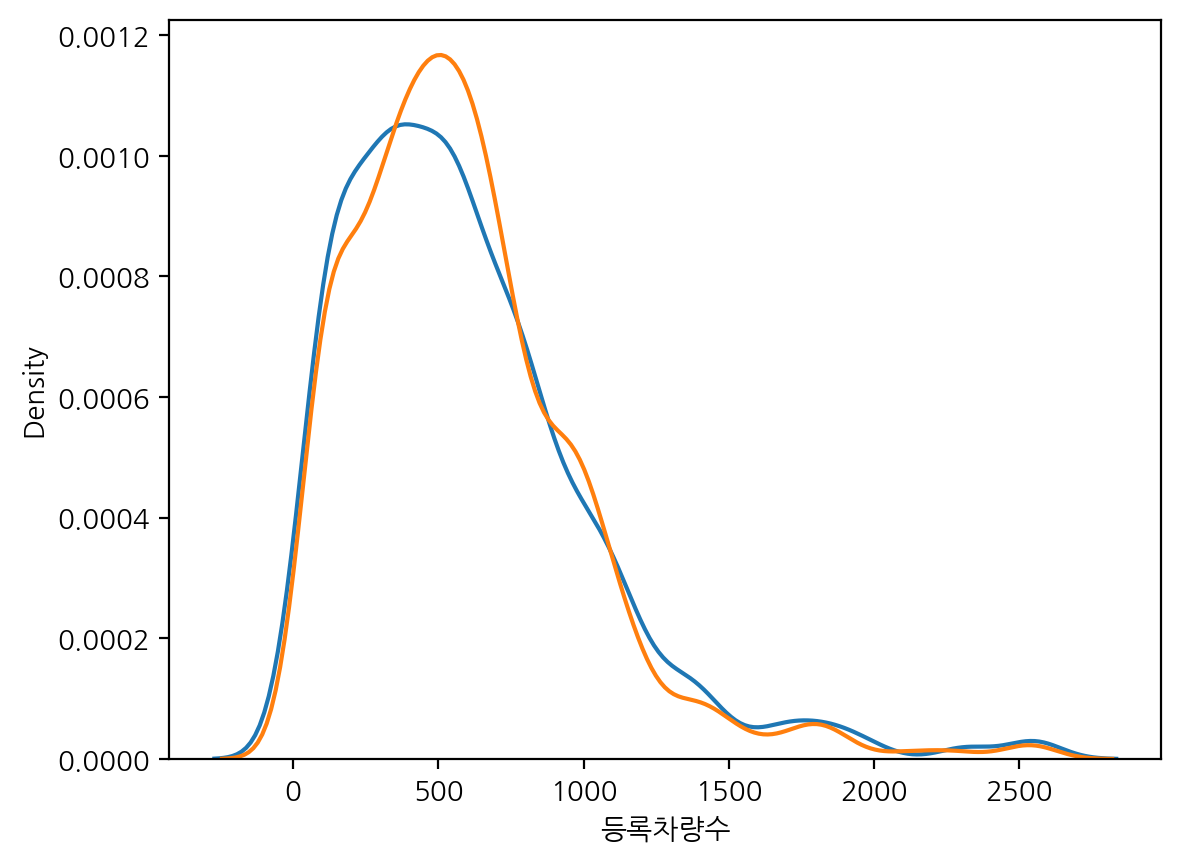

In [41]:
sns.kdeplot(y_train)
sns.kdeplot(y_valid_pred)

In [48]:
X_test

,총세대수,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 버스정류장 수,단지내주차면수
단지코드,,,,,,,
C1072,-0.0325,0.2969,0.0625,0.2438,0.3592,-0.5000,0.2538
C1072,-0.0325,-0.3750,0.0625,1.0021,0.8320,-0.5000,0.2538
C1072,-0.0325,0.2656,0.0625,1.0021,0.8320,-0.5000,0.2538
C1072,-0.0325,0.3281,0.0625,1.0021,0.8320,-0.5000,0.2538
C1072,-0.0325,-0.1406,0.0625,1.4295,1.2006,-0.5000,0.2538
...,...,...,...,...,...,...,...
C1267,-0.1751,0.3750,1.5625,-1.0660,-1.1344,-1.0000,-0.1523
C2189,-0.7040,0.1406,2.0000,-0.6718,-0.2972,-0.5000,-0.4662
C2189,-0.7040,-0.4531,2.0000,-0.6718,-0.2972,-0.5000,-0.4662


In [49]:
y_predict = catb.fit(X, y).predict(X_test)
y_predict

0:	learn: 302.8152810	total: 1.62ms	remaining: 811ms
1:	learn: 293.2767315	total: 3.1ms	remaining: 772ms
2:	learn: 282.9461362	total: 4.38ms	remaining: 726ms
3:	learn: 272.0467053	total: 5.55ms	remaining: 688ms
4:	learn: 262.4685539	total: 6.72ms	remaining: 665ms
5:	learn: 253.5520550	total: 7.98ms	remaining: 657ms
6:	learn: 244.9908919	total: 9.29ms	remaining: 654ms
7:	learn: 237.3569900	total: 10.8ms	remaining: 665ms
8:	learn: 231.1311097	total: 12.1ms	remaining: 661ms
9:	learn: 224.8638713	total: 13.4ms	remaining: 657ms
10:	learn: 219.0879337	total: 14.8ms	remaining: 660ms
11:	learn: 212.9157426	total: 16ms	remaining: 651ms
12:	learn: 206.8054254	total: 17.3ms	remaining: 648ms
13:	learn: 201.3108273	total: 18.6ms	remaining: 644ms
14:	learn: 195.9213738	total: 19.7ms	remaining: 638ms
15:	learn: 190.8188330	total: 20.9ms	remaining: 631ms
16:	learn: 185.4794654	total: 22.4ms	remaining: 636ms
17:	learn: 180.9445546	total: 23.8ms	remaining: 639ms
18:	learn: 177.2634618	total: 25.3ms	rema

array([ 664.74331493,  691.32647587,  700.48056029,  700.50591202,
        698.80322171,  697.56871693,  707.87074028,  698.87395717,
       1174.78808082, 1151.41009092, 1144.00635887, 1209.33734157,
       1213.99962407, 1220.0187929 , 1238.35671567, 1301.5735873 ,
       1261.36111961,  589.09939389,  602.31928455,  604.3550046 ,
        611.81201756,  624.55935925,  618.34979448,  639.11989482,
        619.30111656,  563.48200843,  561.82148382,  600.51913603,
        592.69706749, 1112.11899205, 1110.97674806, 1185.48285691,
       1188.10258163, 1204.15528638, 1192.29542202, 1194.63149365,
       1193.45237125, 1929.3024929 , 1905.9843556 , 1924.8945249 ,
       1913.9627697 , 1912.06789367, 1925.18469374, 1922.70477304,
       1913.9627697 , 1964.94990222, 1913.54531105, 1894.93919801,
        836.34815552,  861.52601853,  806.9529742 ,  858.39076142,
        856.70709555,  914.40274616,  469.71729029,  515.50015718,
        514.55562518,  506.25891694,  392.73092296,  389.55729

In [50]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [51]:
sample_submission['num'] = catb.predict(y_predict)

In [52]:
sample_submission

,code,num
0,C1072,1280.1772
1,C1128,1280.1772
2,C1456,1280.1772
3,C1840,1280.1772
4,C1332,1280.1772
...,...,...
145,C2456,1280.1772
146,C1266,1280.1772
147,C2152,1280.1772
148,C1267,1280.1772


In [ ]:
sample_submission.to_csv('submission_catb_baseline_20210622.csv', index=False)